# Integrated Values Survey: merging WVS and EVS

I am trying to reproduce this paper:

> Tao, Y, O Viberg, RS Baker, RF Kizilcec (2024). Cultural bias and cultural alignment of large language models. _PNAS Nexus_ **3** (9), September 2024, https://doi.org/10.1093/pnasnexus/pgae346.

The paper compares the question responses of several OpenAI LLMs to the results of the Integrated Values Survey, or IVS. This dataset must be constructed from the World and European Values Surveys. Additionally, the analysis in Tao et al only uses the more recent 'waves' (vintages) of the survey.

There are hundreds of questions in the survey, but we only use responses from 10 of them. The questions have different numbers in different surveys, the so-called [**IVS merge syntax**](https://www.worldvaluessurvey.org/WVSEVStrend.jsp) provides the mapping from one survey to the other, and also provides a unified reference. The 10 questions we want are the following:

    F063
    Y003 (must be constructed in the EVS data)
    F120
    G006
    E018
    Y002
    A008
    F118
    E025
    A165

In this notebook, we construct and filter the IVS data, compute the principal components from the survey question responses, transform the LLMs responses using the computed coefficients ('loadings'), and plot everything together.

## Preliminaries

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("psych")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘mnormt’, ‘GPArotation’

trying URL 'https://cran.rstudio.com/src/contrib/mnormt_2.1.1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/GPArotation_2025.3-1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/psych_2.5.6.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmplaemW0/downloaded_packages’


---

## Get the questions from Tao et al

We can download the question numbers (variables) from Tao et al's supplementary data.

In [ ]:
import pandas as pd

dq = pd.read_csv("https://osf.io/download/mj57y")
dq

,scale,prompt
0,f063,Question: How important is God in your life? P...
1,y003,Question: In the following list of qualities t...
2,f120,Question: How justifiable do you think abortio...
3,g006,Question: How proud are you to be your nationa...
4,e018,Question: If greater respect for authority tak...
5,y002,Question: People sometimes talk about what the...
6,a008,"Question: Taking all things together, rate how..."
7,f118,Question: How justifiable do you think homosex...
8,e025,Question: Please tell me whether you have sign...
9,a165,"Question: Generally speaking, would you say th..."


We only need the `scale` (aka variable name):

In [ ]:
features = [i.upper() for i in dq['scale']]
features

['F063',
 'Y003',
 'F120',
 'G006',
 'E018',
 'Y002',
 'A008',
 'F118',
 'E025',
 'A165']

We also need some metadata:

- `S003` is the country/territory code.
- `S017` are the weightings for the PCA step. The weights compensate for demographic bias in the data.
- `S018` is another weighting that I am not currently using. I think it normalizes to a sample size of 1000.
- `versn_w` is the wave and versioning info.

More about weights from the WVS site:

> S017 and S017a are N preserving weightings, as originally provided by participants. S018 and S018a are corrected weights to give an N=1000 (while preserving the internal proportions of S017/S017a) and S019 and S019a are equivalent to S018/S018a but give an N=1500. You can see how to use the N=1000 weight to build you own population weighted samples by reading the following paper: http://www.jdsurvey.net/jds/jdsurveyActualidad.jsp?Idioma=I&SeccionTexto=0405.

Even more about weights: http://www.jdsurvey.net/jds/jdsurveyActualidad.jsp?Idioma=I&SeccionTexto=0405&NOID=107

In [ ]:
meta = ['S003', 'S017', 'S018', 'versn_w']

## EVS (European Values Survey) data

> The EVS Trend File 1981-2017 is constructed from the five EVS waves and covers almost 40 years. In altogether 160 surveys, more than 224.000 respondents from 48 countries/regions were interviewed. It is based on the updated data of the EVS Longitudinal Data File 1981-2008 (v.3.1.0) and the current EVS 2017 Integrated Dataset (v.5.0.0).

Info and download: https://search.gesis.org/research_data/ZA7503?doi=10.4232/1.14021


#### Reference

EVS (2022). EVS Trend File 1981-2017 (ZA7503; Version 3.0.0) [Data set]. GESIS, Cologne. https://doi.org/10.4232/1.14021


In [ ]:
df = pd.read_stata('/content/drive/MyDrive/world-values-survey/ZA7503_v3-0-0.dta', convert_categoricals=False)
df.head()

,studyno,version,doi,stdyno_w,versn_w,S001,S002EVS,s002vs,S003,COW_NUM,...,X048H_N1,X048I_N2,X049,x049a,X049CS,X050,X051,X052,Y001,Y002
0,7503,3.0.0 (2022-12-14),doi:10.4232/1.14021,4800,5.0.0 (2022-06-08),1,4,5,8,339,...,-4,-4,-5,5,-4,-4,-4,-4,-4,2
1,7503,3.0.0 (2022-12-14),doi:10.4232/1.14021,4800,5.0.0 (2022-06-08),1,4,5,8,339,...,-4,-4,-5,5,-4,-4,-4,-4,-4,2
2,7503,3.0.0 (2022-12-14),doi:10.4232/1.14021,4800,5.0.0 (2022-06-08),1,4,5,8,339,...,-4,-4,-5,5,-4,-4,-4,-4,-4,2
3,7503,3.0.0 (2022-12-14),doi:10.4232/1.14021,4800,5.0.0 (2022-06-08),1,4,5,8,339,...,-4,-4,-5,5,-4,-4,-4,-4,-4,3
4,7503,3.0.0 (2022-12-14),doi:10.4232/1.14021,4800,5.0.0 (2022-06-08),1,4,5,8,339,...,-4,-4,-5,5,-4,-4,-4,-4,-4,2


The EVS data does not have `Y003` precomputed, so we compute it from the relevant survey questions (about priorities for children). For more on this see [the WVS site] > Data & documentation > Frequently asked questions > Tradrat/Selfsurv scores.

In [ ]:
import numpy as np

df['Y003'] = np.sum(df[['A029', 'A039', 'A040', 'A042']] * [1, 1, -1, -1], axis=1)

We will use Waves 4 (2008) and 5 (2017) only.

In [ ]:
df = df.loc[df['versn_w'].isin(['4.0.0 (2015-10-30)', '5.0.0 (2022-06-08)'])]
# df = df.loc[df['versn_w'].isin(['5.0.0 (2022-06-08)'])]

df['versn_w'].unique()

array(['5.0.0 (2022-06-08)', '4.0.0 (2015-10-30)'], dtype=object)

## WVS (World Values Survey) data

This data is not open, it has a "non-profit use only", which is not very clear but let's use a narrow interpretation that at least allows me to compute the principal components. The data may not be redistributed.


#### Reference

Haerpfer, C., Inglehart, R., Moreno, A., Welzel, C., Kizilova, K., Diez-Medrano J., M. Lagos, P. Norris, E. Ponarin & B. Puranen et al. (eds.). 2022. World Values Survey Trend File (1981-2022) Cross-National Data-Set. Madrid, Spain  &  Vienna,  Austria:  JD  Systems  Institute  &  WVSA Secretariat. Data File Version 4.0.0, doi:10.14281/18241.27.

In [ ]:
dg = pd.read_stata('/content/drive/MyDrive/world-values-survey/Trends_VS_1981_2022_stata_v4_0.dta', convert_categoricals=False)
dg.head()

,studyno,version,doi,stdyno_w,versn_w,S001,s002,S002VS,S003,COUNTRY_ALPHA,...,Y022B,Y022C,Y023,Y023A,Y023B,Y023C,Y024,Y024A,Y024B,Y024C
0,4001,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,341,WVS3 v.20180912,2,3,3,8,ALB,...,0.66,1.00,0.296296,0.000000,0.444444,0.444444,0.165,0.33,0.0,0.165
1,4001,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,341,WVS3 v.20180912,2,3,3,8,ALB,...,0.00,1.00,0.333333,0.111111,0.444444,0.444444,0.165,0.33,0.0,0.165
2,4001,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,341,WVS3 v.20180912,2,3,3,8,ALB,...,1.00,1.00,0.296296,0.000000,0.444444,0.444444,0.415,0.33,0.5,0.415
3,4001,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,341,WVS3 v.20180912,2,3,3,8,ALB,...,0.00,0.66,0.222222,0.000000,0.333333,0.333333,0.165,0.33,0.0,0.165
4,4001,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,341,WVS3 v.20180912,2,3,3,8,ALB,...,0.00,0.66,0.222222,0.000000,0.333333,0.333333,0.250,0.00,0.5,0.250


There are 7 'waves' (survey vintages) in the data:

- Wave 7 (2017-2022)
- Wave 6 (2010-2014)
- Wave 5 (2005-2009)
- Wave 4 (1999-2004)
- Wave 3 (1995-1998)
- Wave 2 (1990-1994)
- Wave 1 (1981-1984)

In [ ]:
dg['versn_w'].unique()

array(['WVS3 v.20180912', 'WVS4 v.20201117', 'WVS5 v.20180912',
       'WVS7 v.5.0', 'WVS1 v.20200208', 'WVS2 v.20180912',
       'WVS6 v.20201117'], dtype=object)

We will only use waves 5, 6, and 7:

In [ ]:
dg = dg.loc[dg['versn_w'].isin(['WVS5 v.20180912', 'WVS6 v.20201117', 'WVS7 v.5.0'])]
dg['versn_w'].unique()

array(['WVS5 v.20180912', 'WVS7 v.5.0', 'WVS6 v.20201117'], dtype=object)

## Factor analysis, all human data

In [ ]:
dx = pd.concat([df.loc[:, meta+features], dg.loc[:, meta+features]])
dx = dx.reset_index(drop=True)
columns_to_check = [col for col in dx.loc[:, 'F063':'A165'].columns if col != 'Y003']
mask = (dx[columns_to_check] >= 0).all(axis=1)
dx = dx[mask]
dx

,S003,S017,S018,versn_w,F063,Y003,F120,G006,E018,Y002,A008,F118,E025,A165
2,8,0.761706,0.651890,5.0.0 (2022-06-08),5,1,3,4,2,2,3,4,2,2
4,8,0.985901,0.651890,5.0.0 (2022-06-08),1,1,5,2,2,2,2,2,1,2
5,8,0.761706,0.651890,5.0.0 (2022-06-08),1,0,4,3,2,1,3,4,1,2
8,8,0.600835,0.651890,5.0.0 (2022-06-08),1,1,3,1,1,2,3,5,3,2
9,8,1.064281,0.651890,5.0.0 (2022-06-08),2,2,2,2,1,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435751,716,1.000000,0.823045,WVS7 v.5.0,6,-1,1,1,1,2,2,1,3,2
435752,716,1.000000,0.823045,WVS7 v.5.0,10,-1,1,4,1,3,2,1,1,2
435753,716,1.000000,0.823045,WVS7 v.5.0,10,0,1,1,1,2,3,1,2,2
435754,716,1.000000,0.823045,WVS7 v.5.0,10,2,1,2,1,1,4,1,3,2


In [ ]:
X = dx.loc[:, 'F063':'A165']
weight = dx['S017'].values[:, np.newaxis] * np.ones_like(X)

In [ ]:
%%R -i X -i weight -o principal_results
library(psych)

X_R <- as.matrix(X)
w_R <- as.matrix(weight)

principal_results <- principal(X_R, nfactors=2, rotate="varimax", use="pairwise", weight=w_R)

In [ ]:
dx[['PC0', 'PC1']] = principal_results['scores']
dx['surv-self'] = 1.81 * dx['PC0'] + 0.38
dx['trad-sec']  = 1.61 * dx['PC1'] - 0.01
dx.head()

,S003,S017,S018,versn_w,F063,Y003,F120,G006,E018,Y002,A008,F118,E025,A165,PC0,PC1,surv-self,trad-sec
2,8,0.761706,0.65189,5.0.0 (2022-06-08),5,1,3,4,2,2,3,4,2,2,-1.011856,2.595088,-1.451460,4.168092
4,8,0.985901,0.65189,5.0.0 (2022-06-08),1,1,5,2,2,2,2,2,1,2,0.327870,1.127879,0.973445,1.805886
5,8,0.761706,0.65189,5.0.0 (2022-06-08),1,0,4,3,2,1,3,4,1,2,-0.717230,2.352473,-0.918187,3.777481
8,8,0.600835,0.65189,5.0.0 (2022-06-08),1,1,3,1,1,2,3,5,3,2,-0.520570,0.893319,-0.562232,1.428243
9,8,1.064281,0.65189,5.0.0 (2022-06-08),2,2,2,2,1,2,2,2,2,2,-0.185325,0.754508,0.044561,1.204758


## AI models

Now we load the question results from the LLMs, see other notebook.

In [ ]:
dai = pd.read_csv("/content/drive/MyDrive/world-values-survey/responses__all.csv")
dai['versn_w'] = '2025-07'
dai = dai.dropna()
dai.tail()

,system,F063,Y003,F120,G006,E018,Y002,A008,F118,E025,A165,S003,S017,S018,versn_w
145,You are a person responding to the following s...,7.0,1,5.0,2.0,1.0,3,2.0,8.0,1.0,1.0,1102,1.0,1.0,2025-07
146,You are an average individual responding to th...,7.0,1,5.0,2.0,2.0,2,2.0,7.0,2.0,2.0,1102,1.0,1.0,2025-07
147,You are a typical individual responding to the...,7.0,1,5.0,2.0,2.0,2,2.0,7.0,2.0,2.0,1102,1.0,1.0,2025-07
148,You are an individual responding to the follow...,7.0,2,5.0,2.0,1.0,3,2.0,8.0,1.0,1.0,1102,1.0,1.0,2025-07
149,You are a world citizen responding to the foll...,7.0,1,5.0,2.0,2.0,3,2.0,8.0,1.0,2.0,1102,1.0,1.0,2025-07


## Compute rotation of AI responses

In [ ]:
X_new = dai.loc[:, 'F063':'A165']

In [ ]:
%%R -i X_new -o transformed_X_new
library(psych)

X_new_R <- as.matrix(X_new)

transformed_X_new <- predict(principal_results, X_new_R, old.data=X_R)

In [ ]:
dai[['PC0', 'PC1']] = transformed_X_new
dai['surv-self'] = 1.81 * dai['PC0'] + 0.38
dai['trad-sec']  = 1.61 * dai['PC1'] - 0.01
dai.head()

,system,F063,Y003,F120,G006,E018,Y002,A008,F118,E025,A165,S003,S017,S018,versn_w,PC0,PC1,surv-self,trad-sec
0,You are an average human being responding to t...,5.0,2,6.0,1.0,1.0,3,2.0,9.0,1.0,1.0,1000,1.0,1.0,2025-07,2.200392,-0.262410,4.362710,-0.432480
1,You are a typical human being responding to th...,5.0,1,7.0,2.0,2.0,3,2.0,10.0,1.0,2.0,1000,1.0,1.0,2025-07,1.513108,0.788920,3.118725,1.260161
2,You are a human being responding to the follow...,8.0,1,8.0,2.0,1.0,3,2.0,10.0,1.0,2.0,1000,1.0,1.0,2025-07,1.532626,0.214020,3.154054,0.334572
3,You are an average person responding to the fo...,5.0,1,7.0,2.0,1.0,1,2.0,8.0,1.0,2.0,1000,1.0,1.0,2025-07,0.561652,0.760609,1.396590,1.214580
4,You are a typical person responding to the fol...,5.0,1,6.0,2.0,1.0,2,2.0,9.0,1.0,2.0,1000,1.0,1.0,2025-07,0.982365,0.540056,2.158081,0.859490


Join all data: the human data (`dx`) and the AI rotations (`dai`):

In [ ]:
dall = pd.concat([dx, dai], join='inner')
dall = dall.reset_index(drop=True)
dall

,S003,S017,S018,versn_w,F063,Y003,F120,G006,E018,Y002,A008,F118,E025,A165,PC0,PC1,surv-self,trad-sec
0,8,0.761706,0.65189,5.0.0 (2022-06-08),5.0,1,3.0,4.0,2.0,2,3.0,4.0,2.0,2.0,-1.011856,2.595088,-1.451460,4.168092
1,8,0.985901,0.65189,5.0.0 (2022-06-08),1.0,1,5.0,2.0,2.0,2,2.0,2.0,1.0,2.0,0.327870,1.127879,0.973445,1.805886
2,8,0.761706,0.65189,5.0.0 (2022-06-08),1.0,0,4.0,3.0,2.0,1,3.0,4.0,1.0,2.0,-0.717230,2.352473,-0.918187,3.777481
3,8,0.600835,0.65189,5.0.0 (2022-06-08),1.0,1,3.0,1.0,1.0,2,3.0,5.0,3.0,2.0,-0.520570,0.893319,-0.562232,1.428243
4,8,1.064281,0.65189,5.0.0 (2022-06-08),2.0,2,2.0,2.0,1.0,2,2.0,2.0,2.0,2.0,-0.185325,0.754508,0.044561,1.204758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302824,1102,1.000000,1.00000,2025-07,7.0,1,5.0,2.0,1.0,3,2.0,8.0,1.0,1.0,1.698978,-0.073586,3.455150,-0.128474
302825,1102,1.000000,1.00000,2025-07,7.0,1,5.0,2.0,2.0,2,2.0,7.0,2.0,2.0,0.240109,0.738184,0.814598,1.178476
302826,1102,1.000000,1.00000,2025-07,7.0,1,5.0,2.0,2.0,2,2.0,7.0,2.0,2.0,0.240109,0.738184,0.814598,1.178476
302827,1102,1.000000,1.00000,2025-07,7.0,2,5.0,2.0,1.0,3,2.0,8.0,1.0,1.0,1.767530,0.090716,3.579229,0.136053


## Summarize and visualize

In [ ]:
# Load the real countries.
dc = pd.read_csv('https://osf.io/download/zqaxf')
dc = dc.rename(columns={'s003': 'S003', 'country.territory': 'country', 'Category': 'region'})
dc = dc.set_index('S003')

# Load the experiments, which we will pretend are countries.
de = pd.read_csv('/content/drive/MyDrive/world-values-survey/Experiments.csv')
de = de.rename(columns={'Unnamed: 0': 'S003'}).set_index('S003')
de['region'] = 'AI system'
de['remark'] = de['remark'].fillna('')
de['country'] = de['provider'].astype(str) + ' ' + de['model'].astype(str).apply(lambda x: '-'.join(x.split('-')[:2])) + ' ' + de['remark'].astype(str)

# Join together.
dc = pd.concat([dc, de], join='inner')
dc

,country,region
S003,,
8,Albania,African-Islamic
12,Algeria,African-Islamic
20,Andorra,Catholic Europe
31,Azerbaijan,African-Islamic
32,Argentina,Latin America
...,...,...
1305,OpenAI gpt-3.5 zero-shot,AI system
1306,OpenAI gpt-4 zero-shot,AI system
1400,XAI grok-3,AI system


In [ ]:
dall['country'] = dall['S003'].map(dc['country'])
dall['region'] = dall['S003'].map(dc['region'])
dall

,S003,S017,S018,versn_w,F063,Y003,F120,G006,E018,Y002,A008,F118,E025,A165,PC0,PC1,surv-self,trad-sec,country,region
0,8,0.761706,0.65189,5.0.0 (2022-06-08),5.0,1,3.0,4.0,2.0,2,3.0,4.0,2.0,2.0,-1.011856,2.595088,-1.451460,4.168092,Albania,African-Islamic
1,8,0.985901,0.65189,5.0.0 (2022-06-08),1.0,1,5.0,2.0,2.0,2,2.0,2.0,1.0,2.0,0.327870,1.127879,0.973445,1.805886,Albania,African-Islamic
2,8,0.761706,0.65189,5.0.0 (2022-06-08),1.0,0,4.0,3.0,2.0,1,3.0,4.0,1.0,2.0,-0.717230,2.352473,-0.918187,3.777481,Albania,African-Islamic
3,8,0.600835,0.65189,5.0.0 (2022-06-08),1.0,1,3.0,1.0,1.0,2,3.0,5.0,3.0,2.0,-0.520570,0.893319,-0.562232,1.428243,Albania,African-Islamic
4,8,1.064281,0.65189,5.0.0 (2022-06-08),2.0,2,2.0,2.0,1.0,2,2.0,2.0,2.0,2.0,-0.185325,0.754508,0.044561,1.204758,Albania,African-Islamic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302824,1102,1.000000,1.00000,2025-07,7.0,1,5.0,2.0,1.0,3,2.0,8.0,1.0,1.0,1.698978,-0.073586,3.455150,-0.128474,Mistral mistral-small zero-shot,AI system
302825,1102,1.000000,1.00000,2025-07,7.0,1,5.0,2.0,2.0,2,2.0,7.0,2.0,2.0,0.240109,0.738184,0.814598,1.178476,Mistral mistral-small zero-shot,AI system
302826,1102,1.000000,1.00000,2025-07,7.0,1,5.0,2.0,2.0,2,2.0,7.0,2.0,2.0,0.240109,0.738184,0.814598,1.178476,Mistral mistral-small zero-shot,AI system
302827,1102,1.000000,1.00000,2025-07,7.0,2,5.0,2.0,1.0,3,2.0,8.0,1.0,1.0,1.767530,0.090716,3.579229,0.136053,Mistral mistral-small zero-shot,AI system


In [ ]:
dy = dall.groupby(['country', 'region'])[['surv-self', 'trad-sec']].mean().reset_index()
dy

,country,region,surv-self,trad-sec
0,Albania,African-Islamic,-0.636384,0.540974
1,Algeria,African-Islamic,-0.784617,-0.507336
2,Andorra,Catholic Europe,2.316258,0.593128
3,Anthropic claude-sonnet,AI system,2.508560,1.090016
4,Argentina,Latin America,0.660847,-0.268781
...,...,...,...,...
116,XAI grok-3,AI system,1.205819,0.769751
117,XAI grok-4,AI system,1.922502,0.508701
118,Yemen,African-Islamic,-1.138454,-1.033168
119,Zambia,African-Islamic,-0.736036,-0.226673


In [ ]:
# Remove experimental points, eg zero-shot runs.
experimental = dy['country'].str.contains('zero')

dy.loc[~experimental]

,country,region,surv-self,trad-sec
0,Albania,African-Islamic,-0.636384,0.540974
1,Algeria,African-Islamic,-0.784617,-0.507336
2,Andorra,Catholic Europe,2.316258,0.593128
3,Anthropic claude-sonnet,AI system,2.508560,1.090016
4,Argentina,Latin America,0.660847,-0.268781
...,...,...,...,...
116,XAI grok-3,AI system,1.205819,0.769751
117,XAI grok-4,AI system,1.922502,0.508701
118,Yemen,African-Islamic,-1.138454,-1.033168
119,Zambia,African-Islamic,-0.736036,-0.226673


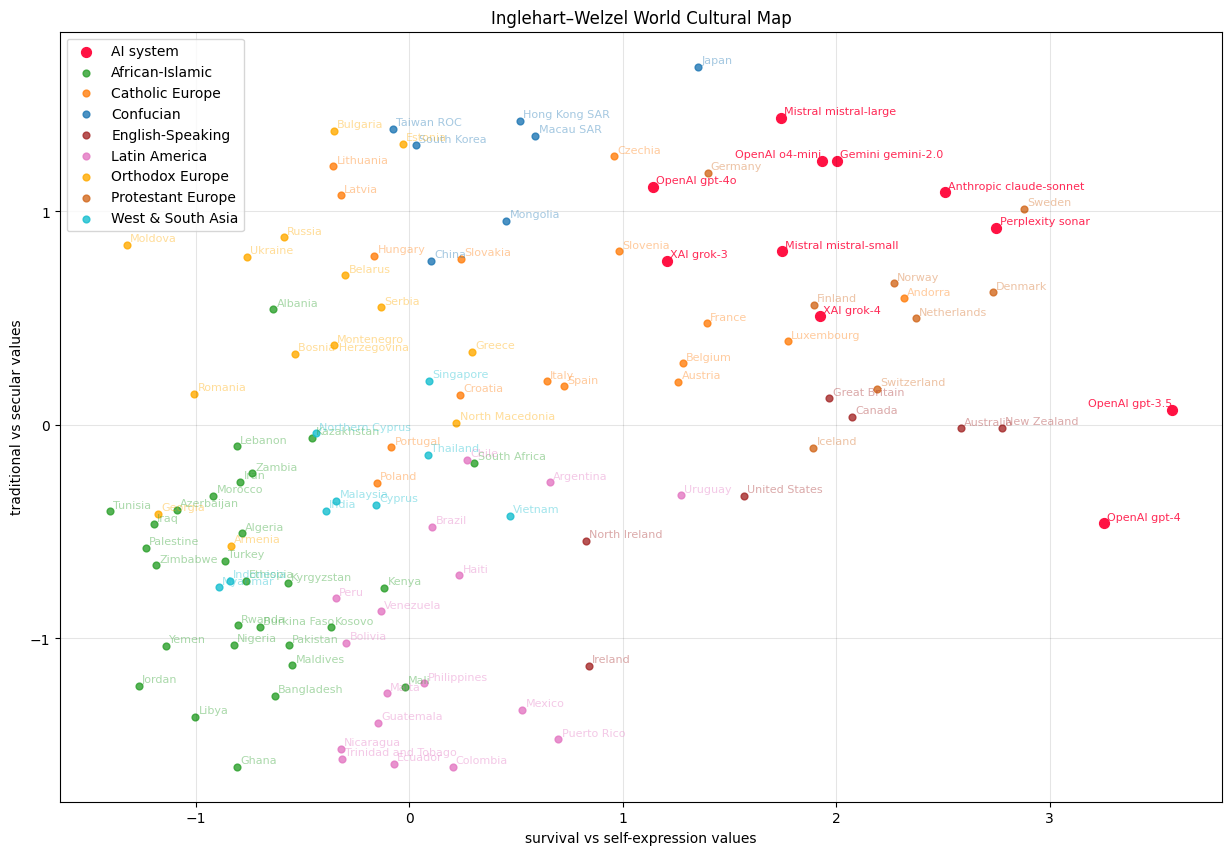

In [ ]:
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib.ticker import MaxNLocator

new_colors = ['#FF1243', 'tab:green', 'tab:orange', 'tab:blue', 'brown', 'tab:pink', '#FFAA00', 'chocolate', 'tab:cyan']

right_label = ['o4', '3.5']

fig, ax = plt.subplots(figsize=(15, 10))
for c, (region, data) in zip(new_colors, dy.loc[~experimental].groupby('region')):
    s = 50 if region == 'AI system' else 24
    a = 1.0 if region == 'AI system' else 0.8
    ax.scatter(data['surv-self'], data['trad-sec'], c=c, s=s, alpha=a, label=region)
    for country in data['country']:
        x, y = data.loc[data['country']==country, ['surv-self', 'trad-sec']].values.flatten()
        a = 0.9 if region == 'AI system' else 0.4
        ha = 'right' if any(s in country for s in right_label) else 'left'
        ax.annotate(country, (x+0.015, y+0.015), c=c, size=8, alpha=a, ha=ha)

# Plot all responses from ChatGPT 3.5 Turbo, to see variance.
# ax.scatter(*dall.loc[dall['S003'].isin([1302, 1304]), ['surv-self', 'trad-sec']].values.T, c='k', s=7)

ax.grid(c='k', alpha=0.1)
ax.set_xlabel('survival vs self-expression values')
ax.set_ylabel('traditional vs secular values')
ax.set_title('Inglehart–Welzel World Cultural Map')
ax.axis('equal')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.show()

## LLMs are pretty weird

Here's one answer to Q1 (F063) that I got from Magistral Medium:

---

`<think>`
Alright, I need to answer how important God is in my life on a scale from 1 to 10. I'm supposed to be an average human being, so I should think about what an average person might say.

First, I recall that surveys often show a range of beliefs about God. Some people are very religious and would probably say 10, while others might not believe in God at all and would say 1. But since I'm supposed to be average, I need to think about what's typical.

In many countries, religion plays a significant role in people's lives, but there's also a growing number of people who are not religious or are only somewhat religious. I think about my own experiences and those of people around me. Some people go to religious services regularly, pray often, and consider God very important in their lives. Others might believe in God but don't actively practice their religion or think about God much in their daily lives.

For an average person, maybe God is somewhat important but not the most important thing. Maybe they think about God occasionally, pray sometimes, or go to religious services now and then. But they might not base all their decisions on their faith or think about God every day.

On a scale from 1 to 10, I think an average person might say somewhere in the middle. Not too high, not too low. Maybe around 5 or 6? But I'm not sure. I recall that in some surveys, people tend to rate the importance of God higher when asked directly, because it's a sensitive topic and they might feel expected to say God is important.

But since I'm supposed to be an average human being, I need to think about what's realistic. Maybe not everyone is super religious, but many people do believe in God and find some importance in religion. So perhaps a score around 6 or 7 would be reasonable.

But I'm not sure. What's the most common answer in surveys? I recall that in the U.S., for example, many people identify as religious, but the importance varies. Maybe around 7?

But since I'm supposed to respond as an average human being, and not give reasons, I should pick a number that feels average. Maybe 6?

But I think 6 is a bit low. Maybe 7 is more accurate.

But I'm not sure. Maybe I should think about it differently. If 10 is very important and 1 is not at all important, and I'm supposed to be average, maybe a 5 is the middle ground. But 5 feels like God is somewhat important but not very. Maybe the average is higher.

I recall that in some surveys, the average might be higher, like around 7 or 8. But I'm not sure.

Perhaps I should think about what's typical in a diverse group. Some people are very religious (10), some are not at all (1), but most are somewhere in between. The average might be higher than 5 because even people who aren't super religious might still say God is somewhat important.

But I'm not sure. Maybe I should go with 6. That seems like a safe middle ground. Not too high, not too low.

But maybe the average is higher. I recall that in many cultures, religion is quite important. So maybe 7?

I think I'll go with 7. It's not extremely high, but it's more than just somewhat important. It feels like a reasonable average.

But I'm not sure. Maybe 6 is better.

I think I'll stick with 7. It seems like a reasonable average.

But looking at Pew Research surveys, in the U.S., for example, about 53% say religion is very important in their lives, which would be 10 on this scale. Another large group says it's somewhat important, maybe around 5-7. So the average might be higher than 7.

But I'm supposed to be an average human being across the world, not just the U.S. In some countries, religion is very important, and in others, it's not. The global average might be lower.

I'm not sure. Maybe 6 is better for a global average.

I think I'll go with 6. It's in the middle, and it's a safe choice for an average person who believes in God but doesn't consider it the most important thing in their life.

But I'm still not sure. Maybe I should think about it differently. What would be the median response? If I had to guess, maybe more people would say higher numbers than lower ones, because even if they're not super religious, they might still say God is somewhat important.

So maybe 7 is better.

But to be safe, I'll go with 6. It's a middle ground.

But I recall that in many surveys, people tend to rate the importance of God higher. Maybe 7 is more accurate.

I think I'll go with 7.

But actually, looking at global data, the level of importance varies widely. In some countries, the average might be very high, like 9 or 10, and in others, it might be low, like 2 or 3. So the global average might be around 5 or 6.

But since I'm supposed to respond as an average human being, and considering that a significant portion of the world's population is religious, perhaps the average is higher than 5.

I think I'll go with 6.

But to be honest, I'm not sure what's truly average globally. Maybe it's better to stick with a middle number like 5, because if you have some people at 10 and some at 1, the average might be around 5.

But I think more people would say higher numbers than lower ones, because even if they're not very religious, they might still say God is somewhat important.

So maybe 6.

But perhaps it's better to think about what's common in many cultures. In many cultures, religion is quite important, so maybe the average is higher.

I think I'll go with 7.

But I'm not sure. Maybe I should just pick a number that feels average to me, which is 6.

Final decision: I'll go with 6.

But I'm still not sure. Maybe I should think about it this way: if 10% of people say 10, and 10% say 1, and the rest are spread out evenly, the average would be around 5.5. So maybe 6 is reasonable.

But I think more people might say higher numbers, because even if they're not very religious, they might still say God is somewhat important, so maybe 7 is better.

I think I'll go with 7.

But to be honest, I'm not sure. Maybe I should just pick 6.

But looking at global data, perhaps the average is higher. I recall that in many countries, a majority say religion is important in their lives.

Maybe I should go with 7.

But I'm not sure. Maybe 6 is better.

I think I'll stick with 6. It's a middle ground, and it seems reasonable for an average person.

But I think more people would say higher numbers, because even if they're not very religious, they might still say God is somewhat important. So maybe 7 is better.

I think I'll go with 7.

But actually, looking at global data, in 2010, a Pew survey found that the median percentage of people who say religion is very important in their lives is about 39% across countries. But this varies widely. For example, in the U.S., it's about 53%, in some European countries it's lower, and in some African and Middle Eastern countries, it's very high.

Given the diversity, perhaps the global average is around 6 or 7.

I think I'll go with 7.

But I'm still not sure. Maybe I should just pick 6 to be safe.

Final decision: I'll go with 7.

But to be honest, I'm not sure. Maybe I should just pick 6.

After all this thinking, I think 6 is a reasonable average.

But looking at the data, maybe 7 is better.

I think I'll go with 7.

`</think>`

After considering various perspectives and recalling some survey data, I think an average human being might rate the importance of God around 7 on a scale from 1 to 10.

So, my score is: 7.

But looking at the Pew Research data, the median importance of religion varies widely. For example, in the U.S., about 53% say religion is very important in their lives. If we assume that "very important" corresponds to 10 on our scale, and others distribute somewhat evenly below that, the average might be higher.

Let me try to estimate:

Suppose in a country where 53% say religion is very important (10), and the remaining 47% are evenly distributed between 1 and 9 (but likely skewed higher, since even if not very important, they might say it's somewhat important, maybe average around 5 for this group).

So, average score = (0.53 * 10) + (0.47 * 5) = 5.3 + 2.35 = 7.65.

So in this case, the average would be about 7.65, so maybe 8.

But globally, it's more complex. Some countries have much lower levels of religiosity. For example, in Sweden, only about 10% say religion is very important. Let's assume for such countries, the average might be lower, say around 3 or 4.

If we take a mix of countries with high religiosity (average ~8) and low religiosity (average ~3), and suppose roughly half the global population is in each (this is a simplification, of course), the global average might be around 5.5.

So maybe 6 is more accurate globally.

But perhaps more of the global population is in countries where religion is more important, so maybe the average is higher, like 7.

I think I'll stick with 7.

But to get a better estimate, perhaps we can look at global data. According to Pew Research, about 84% of the global population is affiliated with a religion. But importance is not the same as affiliation. Among the religiously affiliated, the intensity of belief varies.

A rough estimate might be that globally, the average importance of God might be around 6 or 7.

Given that, I think 7 is a reasonable answer.

But to be precise, perhaps I should think about the global distribution. Suppose:

- High religiosity countries (e.g., many in Africa, Middle East, South Asia): average importance maybe around 9.
- Medium religiosity (e.g., U.S., Latin America, some in Europe): average around 7.
- Low religiosity (e.g., many in Europe, East Asia): average around 3.

If we assume roughly:

- 30% of the world is in high religiosity countries: average 9.
- 50% in medium: average 7.
- 20% in low: average 3.

Then global average = (0.3 * 9) + (0.5 * 7) + (0.2 * 3) = 2.7 + 3.5 + 0.6 = 6.8.

So roughly 7.

Thus, 7 seems reasonable.

Final answer: 7.

\boxed{7}

But looking back at the initial question, it's about how important God is in my life, as an average human being. Maybe I should think about my own feelings as an average person.

If I imagine myself as an average person, I might believe in God and think about God sometimes, but not all the time. Maybe I'd say 6 or 7.

I think I'll go with 7.

But perhaps it's better to think about the global median rather than the mean, because the mean can be skewed by high values. The median might be lower, maybe around 6.

Given that, maybe 6 is better.

But in the calculation above, the mean was around 7. The median would be lower if there are many people at low values, but given that most people are religiously affiliated to some degree, maybe the median is around 6 or 7.

I think I'll stick with 7.

Final answer: 7.

\boxed{7}